In [134]:
import sys
import penaltyblog as pb
sys.path.append("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

data = pd.read_csv("brazil.csv", sep=';', encoding='latin1')
df = data[data.Year == 2007]
df.head()

,Date,Year,Home,Away,HG,AG
380,12/05/2007,2007,Figueirense,Athletico,3,6
381,12/05/2007,2007,Fluminense,Cruzeiro,2,2
382,12/05/2007,2007,São Paulo,Goiás,2,0
383,13/05/2007,2007,Atlético Mineiro,Náutico,2,1
384,13/05/2007,2007,Internacional,Botafogo,2,3


# Custom functions

In [67]:
def simulate_season(df, model):

    simulated_results = []

    for index, row in df.iterrows():
        home_team = row['Home']
        away_team = row['Away']
        
        probs = model.predict(home_team, away_team)
        home_goal_expectation = probs.home_goal_expectation
        away_goal_expectation = probs.away_goal_expectation
        
        home_goals = np.random.poisson(home_goal_expectation)
        away_goals = np.random.poisson(away_goal_expectation)
        
        result = {
            'Home': home_team,
            'Away': away_team,
            'HG': home_goals,
            'AG': away_goals
        }
        simulated_results.append(result)

    return pd.DataFrame(simulated_results)

def calculate_standings(matches):
    team_stats = {}

    for index, row in matches.iterrows():
        home_team = row['Home']
        away_team = row['Away']
        home_goals = row['HG']
        away_goals = row['AG']
        
        # Update or initialize stats for home team
        if home_team in team_stats:
            team_stats[home_team]['GF'] += home_goals
            team_stats[home_team]['GA'] += away_goals
            team_stats[home_team]['GD'] += (home_goals - away_goals)
            team_stats[home_team]['PTS'] += (3 if home_goals > away_goals else (1 if home_goals == away_goals else 0))
            team_stats[home_team]['P'] += 1
        
            if home_goals > away_goals:
                team_stats[home_team]['W'] += 1
            elif home_goals == away_goals:
                team_stats[home_team]['D'] += 1
            else:
                team_stats[home_team]['L'] += 1
        else:
            team_stats[home_team] = {'GF': home_goals, 'GA': away_goals, 'GD': (home_goals - away_goals),
                                    'PTS': (3 if home_goals > away_goals else (1 if home_goals == away_goals else 0)),
                                    'P': 1, 'W': 1 if home_goals > away_goals else 0,
                                    'D': 1 if home_goals == away_goals else 0, 'L': 1 if home_goals < away_goals else 0}

        # Update or initialize stats for away team
        if away_team in team_stats:
            team_stats[away_team]['GF'] += away_goals
            team_stats[away_team]['GA'] += home_goals
            team_stats[away_team]['GD'] += (away_goals - home_goals)
            team_stats[away_team]['PTS'] += (3 if away_goals > home_goals else (1 if away_goals == home_goals else 0))
            team_stats[away_team]['P'] += 1
            
            if away_goals > home_goals:
                team_stats[away_team]['W'] += 1
            elif away_goals == home_goals:
                team_stats[away_team]['D'] += 1
            else:
                team_stats[away_team]['L'] += 1
        else:
            team_stats[away_team] = {'GF': away_goals, 'GA': home_goals, 'GD': (away_goals - home_goals),
                                    'PTS': (3 if away_goals > home_goals else (1 if away_goals == home_goals else 0)),
                                    'P': 1, 'W': 1 if away_goals > home_goals else 0,
                                    'D': 1 if away_goals == home_goals else 0, 'L': 1 if away_goals < home_goals else 0}

    standings = pd.DataFrame.from_dict(team_stats, orient='index')
    standings.index.name = 'Team'

    # Calculate additional stats like Goal Difference, Wins, Draws, Losses, and Points Percentage
    standings['GD'] = standings['GF'] - standings['GA']
    standings['%'] = round((standings['PTS'] / (standings['P'] * 3)) * 100, 1)

    # Sort the standings by Points, Goal Difference, and Goals For
    standings = standings.sort_values(by=['PTS', 'W', 'GD', 'GF'], ascending=False)

    # Add Position (Pos) column
    standings.reset_index(inplace=True)
    standings['Pos'] = standings.index + 1
    standings.set_index('Pos', inplace=True)
    standings.index.name = 'Pos'
    standings = standings[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
    standings.reset_index(inplace=True)

    return standings

# Modelling

In [148]:
rs = pb.models.RueSalvesenGoalModel(df["HG"], df["AG"], df["Home"], df["Away"])
rs.fit()
rs

Module: Penaltyblog

Model: Rue Salvesen

Number of parameters: 43
Log Likelihood: -1071.7
AIC: 2229.4

Team                 Attack               Defence             
------------------------------------------------------------
América-RN           0.206                -0.478              
Athletico            0.97                 -0.981              
Atlético Mineiro     1.261                -1.007              
Botafogo             1.279                -0.905              
Corinthians          0.694                -0.94               
Cruzeiro             1.481                -0.932              
Figueirense          1.159                -0.931              
Flamengo             1.081                -1.014              
Fluminense           1.063                -1.196              
Goiás                1.008                -0.812              
Grêmio               0.77                 -1.074              
Internacional        0.909                -1.076              
Juventude       

# Simulating a match

In [139]:
num_simulations = 1000
home_team = "São Paulo"
away_team = "Corinthians"

probs = rs.predict(home_team, away_team)
home_goal_expectation = probs.home_goal_expectation
away_goal_expectation = probs.away_goal_expectation

print(home_team, "xG -", home_goal_expectation)
print(away_team, "xG -", away_goal_expectation)

poisson_home_goals = np.random.poisson(home_goal_expectation)
poisson_away_goals = np.random.poisson(away_goal_expectation)

print("\nMATCH SIMULATION")
print(home_team, "-", poisson_home_goals)
print(away_team, "-", poisson_away_goals)

São Paulo xG - 1.6004267380172923
Corinthians xG - 0.4828370903541918

MATCH SIMULATION
São Paulo - 2
Corinthians - 1


# Simulating a match 1000 times

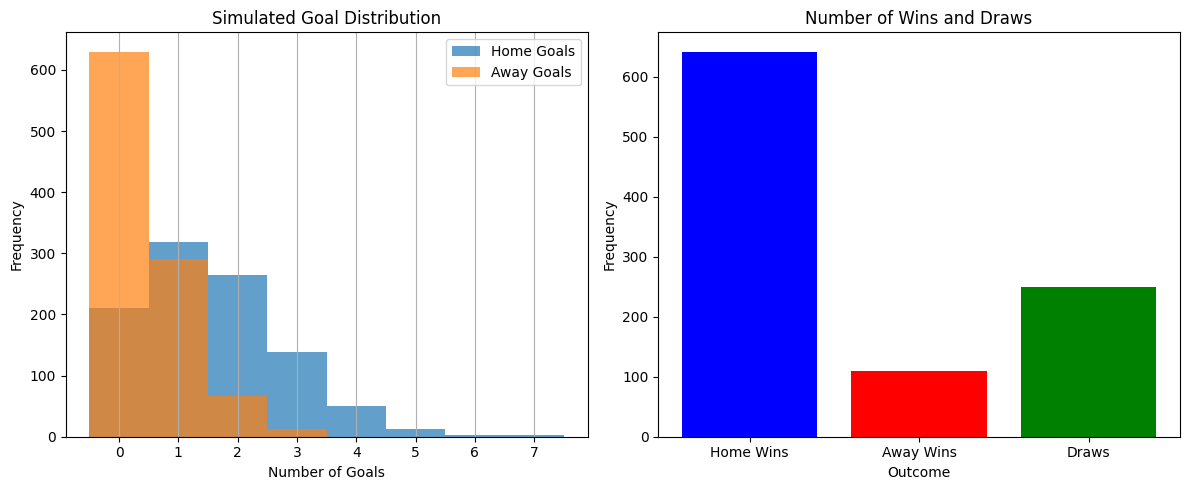

In [140]:
home_goals_simulated = np.random.poisson(home_goal_expectation, num_simulations)
away_goals_simulated = np.random.poisson(away_goal_expectation, num_simulations)

home_wins = np.sum(home_goals_simulated > away_goals_simulated)
away_wins = np.sum(home_goals_simulated < away_goals_simulated)
draws = np.sum(home_goals_simulated == away_goals_simulated)

# Plotting the distributions
plt.figure(figsize=(12, 5))

# Plotting goal distributions
plt.subplot(1, 2, 1)
plt.hist(home_goals_simulated, bins=np.arange(-0.5, max(home_goals_simulated) + 1.5, 1), alpha=0.7, label='Home Goals')
plt.hist(away_goals_simulated, bins=np.arange(-0.5, max(away_goals_simulated) + 1.5, 1), alpha=0.7, label='Away Goals')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.title('Simulated Goal Distribution')
plt.legend()
plt.grid(True, axis='x')

# Plotting win counts
plt.subplot(1, 2, 2)
labels = ['Home Wins', 'Away Wins', 'Draws']
values = [home_wins, away_wins, draws]
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.title('Number of Wins and Draws')

plt.tight_layout()
plt.show()

# Simulating the championship

In [145]:
sim = df.copy()
sim_matches = simulate_season(sim, rs)
sim_standings = calculate_standings(sim_matches)
sim_matches

,Home,Away,HG,AG
0,Figueirense,Athletico,4,1
1,Fluminense,Cruzeiro,2,1
2,São Paulo,Goiás,2,0
3,Atlético Mineiro,Náutico,0,1
4,Internacional,Botafogo,1,1
...,...,...,...,...
375,Santos,Fluminense,0,1
376,Juventude,Sport,1,0
377,Vasco,Paraná,1,0
378,Goiás,Internacional,0,1


# Simulating the championship N times

In [147]:
all_standings = pd.DataFrame()
all_matches = pd.DataFrame()
num_simulations = 50

for i in range(num_simulations):
    matches = simulate_season(sim, rs)
    standings = calculate_standings(matches)
    matches['ID'] = i+1
    standings['ID'] = i+1
    all_matches = pd.concat([all_matches, matches], ignore_index=True)
    all_standings = pd.concat([all_standings, standings], ignore_index=True)

# Now calculate the average standings
average_standings = all_standings.groupby('Team').mean().reset_index()

# Sort the average standings by Points, Goal Difference, and Goals For
average_standings = average_standings.sort_values(by=['PTS', 'GD', 'GF'], ascending=False)

# Add Position (Pos) column
average_standings['Pos'] = average_standings.index + 1
average_standings.set_index('Pos', inplace=True)
average_standings.index.name = 'Pos'
average_standings = average_standings[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
average_standings.reset_index(drop=True, inplace=True)

# Display the average standings
average_standings

,Team,PTS,P,W,D,L,GF,GA,GD,%
0,São Paulo,68.94,38.0,19.36,10.86,7.78,53.08,28.70,24.38,60.466
1,Cruzeiro,59.68,38.0,17.08,8.44,12.48,66.88,54.24,12.64,52.346
2,Fluminense,59.66,38.0,16.62,9.80,11.58,54.62,42.08,12.54,52.328
3,Atlético Mineiro,58.38,38.0,16.50,8.88,12.62,60.70,51.48,9.22,51.220
4,Vasco,57.42,38.0,16.12,9.06,12.82,57.44,48.00,9.44,50.370
5,Botafogo,56.30,38.0,15.68,9.26,13.06,60.60,54.42,6.18,49.386
6,Athletico,54.86,38.0,15.28,9.02,13.70,51.82,48.44,3.38,48.122
7,Internacional,54.74,38.0,15.16,9.26,13.58,48.82,45.96,2.86,48.022
8,Flamengo,54.54,38.0,15.08,9.30,13.62,53.64,49.28,4.36,47.842
9,Santos,54.24,38.0,15.00,9.24,13.76,53.04,48.40,4.64,47.584


# Real standings

In [86]:
real_standings = calculate_standings(df)
real_standings

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,São Paulo,77,38,23,8,7,55,19,36,67.5
1,2,Santos,62,38,19,5,14,57,47,10,54.4
2,3,Flamengo,61,38,17,10,11,55,49,6,53.5
3,4,Fluminense,61,38,16,13,9,57,39,18,53.5
4,5,Cruzeiro,60,38,18,6,14,73,58,15,52.6
5,6,Grêmio,58,38,17,7,14,44,43,1,50.9
6,7,Palmeiras,58,38,16,10,12,48,47,1,50.9
7,8,Atlético Mineiro,55,38,15,10,13,63,51,12,48.2
8,9,Botafogo,55,38,14,13,11,62,58,4,48.2
9,10,Vasco,54,38,15,9,14,58,47,11,47.4


# Comparing Real and Sim standings

In [85]:
# Merge real_standings and sim_standings on 'Team' to compare attributes
comparison = pd.merge(real_standings, average_standings, on='Team', suffixes=('_real', '_sim'))

# Calculate absolute differences for each attribute
attributes = ['PTS', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']
for attr in attributes:
    comparison[f'{attr}_diff'] = abs(comparison[f'{attr}_sim'] - comparison[f'{attr}_real'])

# Reorder columns for better readability (if needed)
comparison = comparison[['Team'] + [f'{attr}_real' for attr in attributes] + [f'{attr}_sim' for attr in attributes] + [f'{attr}_diff' for attr in attributes]]

diff_columns = [col for col in comparison.columns if col.endswith('_diff')]
diff_columns.append('Team')
comparison = comparison[diff_columns]
columns_order = ['Team'] + [col for col in comparison.columns if col != 'Team']
comparison = comparison[columns_order]
comparison.columns = comparison.columns.str.replace('_diff', '')

comparison_rs = comparison
comparison_rs

,Team,PTS,W,D,L,GF,GA,GD,%
0,São Paulo,0.2,1.2,3.8,2.6,0.1,0.0,0.1,0.23
1,Santos,5.7,3.5,4.8,1.3,1.3,1.0,2.3,5.01
2,Flamengo,4.3,1.2,0.7,1.9,1.7,1.7,0.0,3.78
3,Fluminense,1.1,1.3,2.8,1.5,6.6,2.2,4.4,0.98
4,Cruzeiro,2.1,1.7,3.0,1.3,5.2,0.8,4.4,1.81
5,Grêmio,5.0,2.6,2.8,0.2,0.1,1.1,1.0,4.40
6,Palmeiras,2.3,0.6,0.5,1.1,1.6,1.9,3.5,2.03
7,Atlético Mineiro,1.0,0.3,0.1,0.4,5.8,0.4,6.2,0.84
8,Botafogo,1.7,2.1,4.6,2.5,1.0,4.5,5.5,1.54
9,Vasco,6.2,1.9,0.5,2.4,0.9,2.0,1.1,5.41


# Comparing the N iterations

## RMSE values

In [101]:
from sklearn.metrics import mean_squared_error

dfs = []

for simulation_id in range(1, num_simulations + 1):
    # Subset the dataframe for each simulation ID
    subset = all_standings[all_standings['ID'] == simulation_id]
    
    # Get the real standings for comparison
    real_subset = real_standings['PTS']
    
    # Check if the simulation data and real standings have the same number of rows
    if len(subset) == len(real_subset):
        # Calculate RMSE for 'PTS' column
        rmse_value = np.sqrt(mean_squared_error(subset['PTS'], real_subset))
        
        # Create DataFrame with ID and RMSE
        df = pd.DataFrame({'ID': [simulation_id], 'RMSE': [rmse_value]})
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
rmse = pd.concat(dfs, ignore_index=True)

rmse['P'] = 1 / rmse['RMSE']
rmse['Prob'] = rmse['P'] / rmse['P'].sum()
rmse = rmse.drop(columns=['P'])
rmse.sort_values(by='RMSE')

,ID,RMSE,Prob
7,8,2.085665,0.159142
8,9,2.224860,0.149185
9,10,2.302173,0.144175
0,1,3.016621,0.110029
5,6,3.892300,0.085275
6,7,4.110961,0.080739
4,5,4.577117,0.072516
2,3,4.759202,0.069742
3,4,5.049752,0.065729
1,2,5.229723,0.063467


## Choosing an iteration

### Matches

In [124]:
random = np.random.choice(rmse['ID'], p=rmse['Prob'])
manual = 1

chosen_matches = all_matches[all_matches.ID == random]
chosen_matches = chosen_matches.drop(columns=['ID'])
chosen_matches

,Home,Away,HG,AG
760,Figueirense,Athletico,1,0
761,Fluminense,Cruzeiro,2,4
762,São Paulo,Goiás,2,0
763,Atlético Mineiro,Náutico,0,1
764,Internacional,Botafogo,0,0
...,...,...,...,...
1135,Santos,Fluminense,0,1
1136,Juventude,Sport,0,1
1137,Vasco,Paraná,3,1
1138,Goiás,Internacional,1,3


### Standings

In [131]:
random = np.random.choice(rmse['ID'], p=rmse['Prob'])
manual = 1

chosen_standings = all_standings[all_standings.ID == random]
chosen_standings = chosen_standings.drop(columns=['ID'])
chosen_standings

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
140,1,São Paulo,72,38,19,15,4,49,22,27,63.2
141,2,Vasco,63,38,18,9,11,55,43,12,55.3
142,3,Athletico,62,38,16,14,8,54,46,8,54.4
143,4,Flamengo,59,38,16,11,11,64,50,14,51.8
144,5,Náutico,58,38,18,4,16,66,53,13,50.9
145,6,Santos,58,38,16,10,12,61,49,12,50.9
146,7,Palmeiras,58,38,16,10,12,41,45,-4,50.9
147,8,Internacional,56,38,16,8,14,53,42,11,49.1
148,9,Botafogo,56,38,16,8,14,59,50,9,49.1
149,10,Fluminense,56,38,15,11,12,48,43,5,49.1
